# Q Learning & Sarsa : Crossing Volcano 

In this Notebook, we'll implement an agent <b>that plays the Volcano crossing problem.</b>

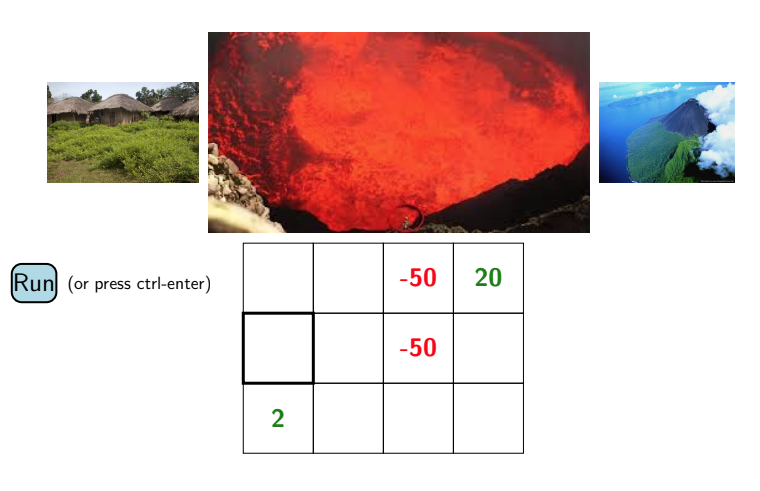
<!-- 
The goal of this game is <b>to go from the starting state (S) to the goal state (G)</b> by walking only on frozen tiles (F) and avoid holes (H). However, the ice is slippery, **so you won't always move in the direction you intend (stochastic environment)**

Thanks to [lukewys](https://github.com/lukewys) for his help -->


## Step 0: Import the dependencies 📚


In [ ]:
import numpy as np
import random
from typing import Optional
from gym import Env, spaces, utils
from tqdm.auto import tqdm
import pandas as pd

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# setting the Directions
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

action2str = [" ⬅️ ", " ⬇️ ", " ➡️ ", " ⬆️ "]

# Creating a Map 
MAPS = {
    "4x3": ["OOVG", 
            "SOVO", 
            "gOOO"],
        
    "8x6": ["SVOOOOOO", 
            "OOVOOOVO", 
            "OOOOOOOO", 
            "VOOgVOOO", 
            "OOOOGVOO", 
            "VOOOOOOO"],    
}


In [ ]:
# Creating the class
class Volcano(Env):

    def __init__(
        self,
        render_mode: Optional[str] = None,
        desc=None,
        # map_name="4x3",
        map_name="8x6",
        slip_prob=0.1,
    ):
        desc = MAPS[map_name]
        self.desc = desc = np.asarray(desc, dtype="c")
        self.nrow, self.ncol = nrow, ncol = desc.shape

        self.map_name = map_name
        self.slip_prob = slip_prob

        nA = 4
        nS = nrow * ncol

        self.initial_state_distrib = np.array(desc == b"S").astype("float64").ravel()
        self.initial_state_distrib /= self.initial_state_distrib.sum()

        self.P = {s: {a: [] for a in range(nA)} for s in range(nS)}
        for row in range(nrow):
            for col in range(ncol):
                s = self.to_s(row, col)
                for a in range(4):
                    letter = desc[row, col]
                    if letter in b"VgG":
                        self.P[s][a].append((1.0, s, 0, True))
                    else:
                        li = self.update_transition(slip_prob, self.P[s][a], row, col, a)
        self.observation_space = spaces.Discrete(nS)
        self.action_space = spaces.Discrete(nA)

    def update_transition(self, slip_prob, li, row, col, a):
      """
        Problem 1: 
        Define the transition probability matrix self.P. 

        The MDP follows a slip probability (slip_prob). If slippery, the agent will randomly move in all the 4 directions;
        
        Input:
         slip_prob: the slippery probability 
         trans_p: the transition probability matrix to update 
         row, col: the current row and column 
         a: the action, reward, terminated) to the list li. 
            This tuple represents the probability of moving in this direction 
            (since there is only one possible direction), the new state, the 
            reward for moving to the new state, and the termination status of 
            the new state
      """
      #########################################PROBLEM 1 STARTS HERE#########################################
      
      # Define possible actions
      actions = [UP, DOWN, LEFT, RIGHT]

      possible_actions = actions.copy()
      if row == 0:
        possible_actions.remove(UP)
      if row+1 == self.nrow:
        possible_actions.remove(DOWN)
      if col == 0:
        possible_actions.remove(LEFT)
      if col+1 == self.ncol:
        possible_actions.remove(RIGHT)
      
      num_possible_actions = len(possible_actions)

      # Calculate position, probability, reward, and determine if terminal for 
      # each possible successor state
      for action in actions:

        if action == UP:
          new_state = (row-1, col)
        if action == LEFT:
          new_state = (row, col-1)
        if action == DOWN:
          new_state = (row+1, col)
        if action == RIGHT:
          new_state = (row, col+1)

        '''
        Treat intended action differently than slipping action:
        ==> Taking desired action happens when slips don't happen and when 
             slips do happen and one coincidentally slips in desired direction
        ==> Taking non-desired action happens when slip does happen and one 
            slides in specific non-desired drirection.
        '''

        new_state_out_of_bounds = any([
            new_state[0] < 0,
            new_state[1] < 0,
            new_state[0] >= self.nrow,
            new_state[1] >= self.ncol,
        ])

        if new_state_out_of_bounds and action == a:
          prob_new_state = (1-slip_prob)
          new_state = (row, col)
        elif new_state_out_of_bounds:
          continue
        elif action == a:
          prob_new_state = (1-slip_prob) + (slip_prob / num_possible_actions)
        else:
          prob_new_state = (slip_prob / num_possible_actions)
      
        new_letter = self.desc[new_state[0], new_state[1]]
        
        reward_new_state = -0.1

        if new_letter in b"VgG":
          terminal_new_state = True

          if new_letter == b'V':
            reward_new_state += -50
          elif new_letter == b'g':
            reward_new_state += 2
          elif new_letter == b'G':
            reward_new_state += 20

        else:
          terminal_new_state = False
        
        transition_mat_update = (
            prob_new_state, 
             self.to_s(new_state[0], new_state[1]), 
             reward_new_state, 
             terminal_new_state
             )

        li.append(transition_mat_update)
        
      return li
      
      # #return li.append((1.0,29,-0.1,True))

      ##############################################END HERE################################################
      


    def to_s(self, row, col):
        return row * self.ncol + col

    def inc(self, row, col, a):
        if a == LEFT:
            col = max(col - 1, 0)
        elif a == DOWN:
            row = min(row + 1, self.nrow - 1)
        elif a == RIGHT:
            col = min(col + 1, self.ncol - 1)
        elif a == UP:
            row = max(row - 1, 0)
        return (row, col)

    def step(self, a):
        transitions = self.P[self.s][a]

        # import pdb; pdb.set_trace()

        i = np.random.choice(range(len(transitions)), p=[t[0] for t in transitions])
        p, s, r, t = transitions[i]
        self.s = s
        self.lastaction = a

        return (int(s), r, t, False, {"prob": p})

    def reset(
        self,
        *,
        seed: Optional[int] = None,
        options: Optional[dict] = None,
    ):
        super().reset(seed=seed)
        
        self.s = np.random.choice(len(self.initial_state_distrib), p=self.initial_state_distrib)
        self.lastaction = None

        return int(self.s), {"prob": 1}

    def render(self):
        desc = self.desc.tolist()
        out_str = ""

        row, col = self.s // self.ncol, self.s % self.ncol
        desc = [[c.decode("utf-8") for c in line] for line in desc]
        desc[row][col] = utils.colorize(desc[row][col], "red", highlight=True)
        if self.lastaction is not None:
            out_str += f"  ({['Left', 'Down', 'Right', 'Up'][self.lastaction]})\n"
        else:
            out_str += "\n"
        out_str += "\n".join("".join(line) for line in desc) + "\n"

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## Step 1: Create the environment 🎮
- Here we'll create the Crossing Volcano environment. 
- OpenAI Gym is a library <b> composed of many environments that we can use to train our agents. Also we can define our own environment.</b>
- In our case we choose to define Crossing Volcano.

In [ ]:
env = Volcano()
print(type(env))

<class '__main__.Volcano'>


## Step 2: Create the Q-table and initialize it 🗄️
- Now, we'll create our Q-table, to know how much rows (states) and columns (actions) we need, we need to calculate the action_size and the state_size
- OpenAI Gym provides us a way to do that: `env.action_space.n` and `env.observation_space.n`

In [ ]:
action_size = env.action_space.n
state_size = env.observation_space.n

## Step 3: Create the hyperparameters ⚙️
- Here, we'll specify the hyperparameters

In [ ]:
TOTAL_EPISODES = 20000       # Total episodes
MAX_STEPS = 99               # Max steps per episode
hyperparameters = {"learning_rate": 0.5, "gamma": 1.0}
hyperparameters

{'learning_rate': 0.5, 'gamma': 1.0}

## Step 4: The Q learning algorithm 🧠
- Now we implement the Q learning algorithm:
  <!-- ![alt text](http://simoninithomas.com/drlc/Qlearning//qtable_algo.png) -->
  ![alt text](https://tcnguyen.github.io/reinforcement_learning/images/Q_learning_algo.png)
  

In [ ]:
def Q_learning(hyperparameters):

    env = hyperparameters['env']

    # Create our Q table with state_size rows and action_size columns 
    qtable = np.zeros((state_size, action_size))    
    learning_rate = hyperparameters["learning_rate"]
    gamma = hyperparameters["gamma"]
    rewards = []
    epsilon = 1.
    for episode in tqdm(range(TOTAL_EPISODES), total=TOTAL_EPISODES):
        state, _ = env.reset()
        step = 0
        done = False
        total_rewards = 0
        for step in range(MAX_STEPS):
            if random.uniform(0, 1) > epsilon:
                action = np.argmax(qtable[state,:])
            else:
                action = env.action_space.sample()
            new_state, reward, done, _, info = env.step(action)
            qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state, :]) - qtable[state, action])
            total_rewards += reward
            state = new_state
            if done == True: 
                break
        rewards.append(total_rewards)
    print ("Score over time: " +  str(sum(rewards)/TOTAL_EPISODES))
    return qtable

## Step 5: The Sarsa algorithm 🧠
- Now we implement the Sarsa algorithm:

![alt text](https://tcnguyen.github.io/reinforcement_learning/images/SARSA_algo.png)

In [ ]:
def SARSA(hyperparameters):
    """
    Problem 2

    Implement the SARSA algorithm.

    Input: hyperparameters including the learning rate the discounting factor

    Output: the qtable learned by SARSA

    """
    qtable = np.zeros((state_size, action_size))
    #########################################PROBLEM 2 STARTS HERE######################################### 
    
    env = hyperparameters['env']
    gamma = hyperparameters['gamma']
    learning_rate = hyperparameters['learning_rate']
    epsilon = hyperparameters['epsilon']     # Exploration rate

    # Define Greedy-Epsilon
    def greedy_epsilon(state, epsilon):

      if random.uniform(0, 1) > epsilon:
        action = np.argmax(qtable[state, :])
      
      else:
        action = env.action_space.sample()
      
      return action
    
    # Updating qtable
    def update_qtable(qtable, state, action, new_state, new_action, reward):

      current_state_q = qtable[state, action]
      new_state_q = qtable[new_state, new_action]
      delta_q = (reward + learning_rate * new_state_q - current_state_q)

      qtable[state, action] = current_state_q + gamma * delta_q
      return qtable

    rewards = []

    # Repeat for each episode
    for episode in tqdm(range(TOTAL_EPISODES), total=TOTAL_EPISODES, desc='Repeat for each episode: '):
      
      S, _ = env.reset() # Initialize S
      A = greedy_epsilon(S, epsilon) # Choose A from S using greedy-epsilon
      R_episode = 0 # Initialize episode-wise reward, R
      finished = False # Finished when S is a terminal-state

      # Repeat for each step
      for step in range(MAX_STEPS):

        # until S is a terminal-state
        if finished: break

        A = greedy_epsilon(S, epsilon) # Take action A
        S_prime, R, finished, _, info = env.step(A) # Observe S_prime and R
        A_prime = greedy_epsilon(S_prime, epsilon) # Choose A_prime from S_prime using greedy-epsilon

        qtable = update_qtable(qtable, S, A, S_prime, A_prime, R) # Update qtable
        
        R_episode += R # Track episode-wise Reward
        S = S_prime # Set S to S_prime
        A = A_prime # Set A to A_prime
      
      # Track rewards across all episodes
      rewards.append(R_episode)

    ####################################END HERE################################################

    print("(SARSA) Score over time: " +  str(sum(rewards)/TOTAL_EPISODES))
    return qtable

In [ ]:
def policy_evaluation(qtable, verbose):
  env.reset()
  rewards = []
  raveled_states = env.desc.ravel()

  for episode in range(100):
      state, _ = env.reset()
      step = 0
      done = False
      if verbose:
        print("****************************************************")
        print("EPISODE ", episode)

      
      for step in range(MAX_STEPS):
          action = np.argmax(qtable[state,:])
          
          new_state, reward, done, _, info = env.step(action)

          if done:

              if verbose:
                img = env.render()
              
                if raveled_states[new_state] == b"g":
                    print("We reached the village 🏠")
                elif raveled_states[new_state] == b"G":
                    print("We reached the fabulous view 🌊")
                else:
                    print("We fell into the volcano 🌋")
                print("Number of steps", step)
              
              rewards.append(reward)
              break
          state = new_state
  print("Average reward of policy:", np.mean(rewards)) 

  return np.mean(rewards)   

In [ ]:
def run_solution(solution, hyperparameters, verbose=False):
  qtable = solution(hyperparameters)

  policy = "\n" + "\n".join(["".join([action2str[x] for x in each_list]) for each_list in np.argmax(qtable, axis=1).reshape((env.nrow, env.ncol))])
  
  if verbose:
    print("Policy: ", policy)

  return policy_evaluation(qtable, verbose=verbose)


In [ ]:
solutions = {'SARSA': SARSA, 'Q-Learning': Q_learning}
hyperparameter_grid = {
    'A': {'env': env, 'learning_rate': 0.5, 'gamma': 1, 'epsilon': 0.6},
    'B': {'env': env, 'learning_rate': 1, 'gamma': 0.001, 'epsilon': 0.3},
    'C': {'env': env, 'learning_rate': 1, 'gamma': 1, 'epsilon': 0.6},
    'D': {'env': env, 'learning_rate': 1, 'gamma': 1, 'epsilon': 0.8},
    'E': {'env': env, 'learning_rate': 0.25, 'gamma': 1.2, 'epsilon': 0.85},
    'F': {'env': env, 'learning_rate': 0.5, 'gamma': 1, 'epsilon': 0.85},
    'G': {'env': env, 'learning_rate': 0.5, 'gamma': 1.01, 'epsilon': 0.85},
    'H': {'env': env, 'learning_rate': 1, 'gamma': 0.001, 'epsilon': 0.6},
    'I': {'env': env, 'learning_rate': 0.01, 'gamma': 1.01, 'epsilon': 0.75},
    'J': {'env': env, 'learning_rate': 0.8, 'gamma': 0.01, 'epsilon': 0.75},
    'K': {'env': env, 'learning_rate': 0.5, 'gamma': 1.5, 'epsilon': 0.75},
    'L': {'env': env, 'learning_rate': 2, 'gamma': 0.0001, 'epsilon': 0.75},

}

In [ ]:
def run_trials(solutions, hyperparameter_grid):

  trials = pd.DataFrame(columns=['solution','learning_rate','gamma','epsilon','avg_reward'])
  for solution_name, solution in solutions.items():

    print('='*75)
    print(f'\n\nSOLUTION: {solution_name}\n\n')

    for hyp_name, hyperparameter in hyperparameter_grid.items():
      print(f'\n==> HYPER PARAMETERS: {hyp_name}')
      avg_reward = run_solution(solution, hyperparameter)
      print('-'*75)

      trial = pd.DataFrame([{
          'solution': solution_name,
          'learning_rate': hyperparameter['learning_rate'], 
          'gamma': hyperparameter['gamma'], 
          'epsilon': hyperparameter['epsilon'], 
          'avg_reward': avg_reward,
          }])
    
      trials = pd.concat([trials, trial]).reset_index(drop=True)
  
  return trials

In [ ]:
trials = run_trials(solutions, hyperparameter_grid)



SOLUTION: SARSA



==> HYPER PARAMETERS: A


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Repeat for each episode:   0%|          | 0/20000 [00:00<?, ?it/s]

(SARSA) Score over time: -44.60801499999778
Average reward of policy: -39.64347826086957
---------------------------------------------------------------------------

==> HYPER PARAMETERS: B


Repeat for each episode:   0%|          | 0/20000 [00:00<?, ?it/s]

(SARSA) Score over time: -19.794524999997808
Average reward of policy: 13.67777777777778
---------------------------------------------------------------------------

==> HYPER PARAMETERS: C


Repeat for each episode:   0%|          | 0/20000 [00:00<?, ?it/s]

(SARSA) Score over time: -49.33936499999206
Average reward of policy: -50.10000000000003
---------------------------------------------------------------------------

==> HYPER PARAMETERS: D


Repeat for each episode:   0%|          | 0/20000 [00:00<?, ?it/s]

(SARSA) Score over time: -49.197414999994045
Average reward of policy: -50.10000000000003
---------------------------------------------------------------------------

==> HYPER PARAMETERS: E


Repeat for each episode:   0%|          | 0/20000 [00:00<?, ?it/s]

(SARSA) Score over time: -48.46963499999683
Average reward of policy: -35.91818181818182
---------------------------------------------------------------------------

==> HYPER PARAMETERS: F


Repeat for each episode:   0%|          | 0/20000 [00:00<?, ?it/s]

(SARSA) Score over time: -48.10459999999649
Average reward of policy: -42.475
---------------------------------------------------------------------------

==> HYPER PARAMETERS: G


Repeat for each episode:   0%|          | 0/20000 [00:00<?, ?it/s]

(SARSA) Score over time: -48.21658499999658
Average reward of policy: -23.06
---------------------------------------------------------------------------

==> HYPER PARAMETERS: H


Repeat for each episode:   0%|          | 0/20000 [00:00<?, ?it/s]

(SARSA) Score over time: -37.54522999999757
Average reward of policy: 12.680000000000005
---------------------------------------------------------------------------

==> HYPER PARAMETERS: I


Repeat for each episode:   0%|          | 0/20000 [00:00<?, ?it/s]

(SARSA) Score over time: -47.49250999999703
Average reward of policy: -49.552631578947405
---------------------------------------------------------------------------

==> HYPER PARAMETERS: J


Repeat for each episode:   0%|          | 0/20000 [00:00<?, ?it/s]

(SARSA) Score over time: -43.83828999999707
Average reward of policy: -3.1505050505050516
---------------------------------------------------------------------------

==> HYPER PARAMETERS: K


Repeat for each episode:   0%|          | 0/20000 [00:00<?, ?it/s]

(SARSA) Score over time: -48.049529999996956
Average reward of policy: -43.5698795180723
---------------------------------------------------------------------------

==> HYPER PARAMETERS: L


Repeat for each episode:   0%|          | 0/20000 [00:00<?, ?it/s]

(SARSA) Score over time: -44.310314999997594
Average reward of policy: -2.580000000000001
---------------------------------------------------------------------------


SOLUTION: Q-Learning



==> HYPER PARAMETERS: A


  0%|          | 0/20000 [00:00<?, ?it/s]

Score over time: -49.09262999999591
Average reward of policy: -22.8
---------------------------------------------------------------------------

==> HYPER PARAMETERS: B


  0%|          | 0/20000 [00:00<?, ?it/s]

Score over time: -49.1722549999962
Average reward of policy: -5.36
---------------------------------------------------------------------------

==> HYPER PARAMETERS: C


  0%|          | 0/20000 [00:00<?, ?it/s]

Score over time: -49.1499599999961
Average reward of policy: -38.786868686868694
---------------------------------------------------------------------------

==> HYPER PARAMETERS: D


  0%|          | 0/20000 [00:00<?, ?it/s]

Score over time: -49.265644999996226
Average reward of policy: -14.56938775510204
---------------------------------------------------------------------------

==> HYPER PARAMETERS: E


  0%|          | 0/20000 [00:00<?, ?it/s]

Score over time: -49.290449999995914
Average reward of policy: -50.10000000000003
---------------------------------------------------------------------------

==> HYPER PARAMETERS: F


  0%|          | 0/20000 [00:00<?, ?it/s]

Score over time: -49.12525999999638
Average reward of policy: -22.35
---------------------------------------------------------------------------

==> HYPER PARAMETERS: G


  0%|          | 0/20000 [00:00<?, ?it/s]

Score over time: -49.27965999999608
Average reward of policy: -50.10000000000002
---------------------------------------------------------------------------

==> HYPER PARAMETERS: H


  0%|          | 0/20000 [00:00<?, ?it/s]

Score over time: -49.21399999999596
Average reward of policy: -7.980000000000001
---------------------------------------------------------------------------

==> HYPER PARAMETERS: I


  0%|          | 0/20000 [00:00<?, ?it/s]

Score over time: -49.17772499999608
Average reward of policy: -3.280000000000001
---------------------------------------------------------------------------

==> HYPER PARAMETERS: J


  0%|          | 0/20000 [00:00<?, ?it/s]

Score over time: -49.319834999996424
Average reward of policy: -45.277777777777786
---------------------------------------------------------------------------

==> HYPER PARAMETERS: K


  0%|          | 0/20000 [00:00<?, ?it/s]

<ipython-input-69-708a668920a4>:19: RuntimeWarning: overflow encountered in double_scalars
  qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state, :]) - qtable[state, action])
<ipython-input-69-708a668920a4>:19: RuntimeWarning: invalid value encountered in double_scalars
  qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state, :]) - qtable[state, action])


Score over time: -49.157044999995904
Average reward of policy: -50.10000000000003
---------------------------------------------------------------------------

==> HYPER PARAMETERS: L


  0%|          | 0/20000 [00:00<?, ?it/s]

Score over time: -49.302929999996294
Average reward of policy: -50.10000000000002
---------------------------------------------------------------------------


In [ ]:
trials.head(15)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,solution,learning_rate,gamma,epsilon,avg_reward
0,SARSA,0.50,1,0.60,-39.643478
1,SARSA,1.00,0.001,0.30,13.677778
2,SARSA,1.00,1,0.60,-50.100000
3,SARSA,1.00,1,0.80,-50.100000
4,SARSA,0.25,1.2,0.85,-35.918182
5,SARSA,0.50,1,0.85,-42.475000
6,SARSA,0.50,1.01,0.85,-23.060000
7,SARSA,1.00,0.001,0.60,12.680000
8,SARSA,0.01,1.01,0.75,-49.552632
9,SARSA,0.80,0.01,0.75,-3.150505


In [ ]:
import matplotlib.pyplot as plt

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
def plot_hyperparameter_performance(hyperparameter_name, trials, map_name):

  data = {
      solution_name: 
      trials[trials.solution == solution_name][[hyperparameter_name, 'avg_reward']]
      for solution_name, solution in solutions.items()
      }

  y_padding = 5
  ymin = min([min(solution_data.avg_reward) for solution_data in data.values()]) - y_padding
  ymax = max([max(solution_data.avg_reward) for solution_data in data.values()]) + y_padding

  fig, axs = plt.subplots(1, len(solutions), figsize=(5*len(solutions), 5))
  for ax, (solution_name, solution_data) in zip(axs, data.items()):

    ax.set_ylim([ymin, ymax])
    ax.grid()

    ax.scatter(solution_data[hyperparameter_name], solution_data['avg_reward'])
    ax.set_title(f'{solution_name} -- {hyperparameter_name} -- {map_name}')
    ax.set_xlabel(f'{hyperparameter_name}')
    ax.set_ylabel(f'Average Reward across {TOTAL_EPISODES} Episodes')

  plt.show()


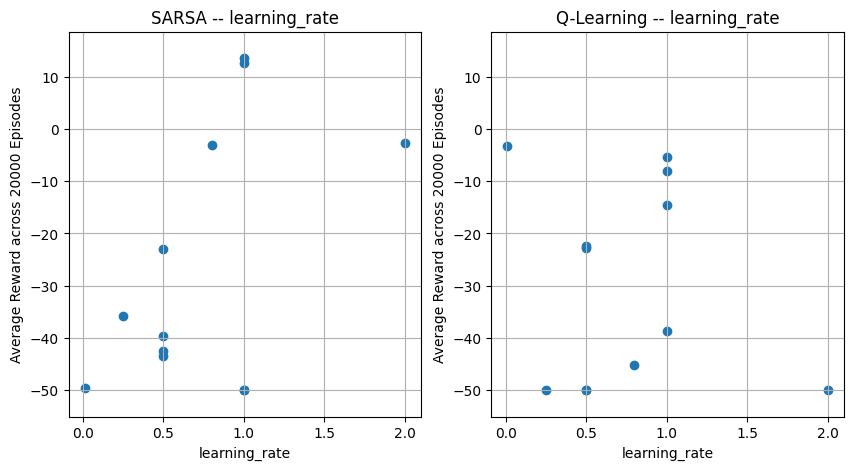

In [ ]:
plot_hyperparameter_performance('learning_rate', trials, env.map_name)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


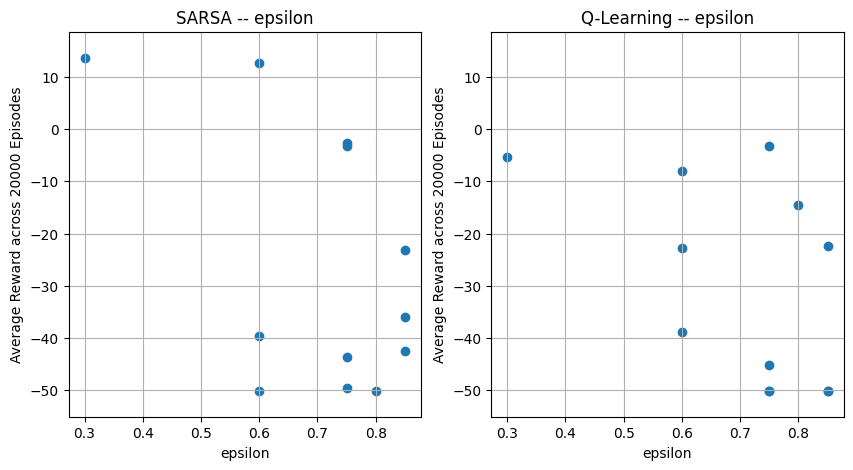

In [ ]:
plot_hyperparameter_performance('epsilon', trials)

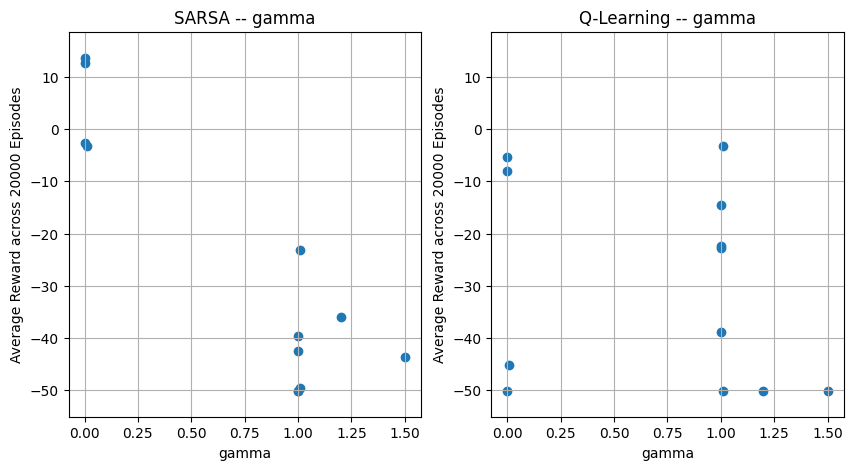

In [ ]:
plot_hyperparameter_performance('gamma', trials)

In [ ]:
MAP_1_ENV = Volcano(map_name='8x6')
MAP_2_ENV = Volcano(map_name='4x3')

In [ ]:
solutions = {'SARSA': SARSA, 'Q-Learning': Q_learning}
hyperparameter_grid_1 = {
    'A': {'env': MAP_1_ENV, 'learning_rate': 0.5, 'gamma': 1, 'epsilon': 0.6},
    'B': {'env': MAP_1_ENV, 'learning_rate': 1, 'gamma': 0.001, 'epsilon': 0.3},
    'C': {'env': MAP_1_ENV, 'learning_rate': 1, 'gamma': 1, 'epsilon': 0.6},
    'D': {'env': MAP_1_ENV, 'learning_rate': 1, 'gamma': 1, 'epsilon': 0.8},
    'E': {'env': MAP_1_ENV, 'learning_rate': 0.25, 'gamma': 1.2, 'epsilon': 0.85},
    'F': {'env': MAP_1_ENV, 'learning_rate': 0.5, 'gamma': 1, 'epsilon': 0.85},
    'G': {'env': MAP_1_ENV, 'learning_rate': 0.5, 'gamma': 1.01, 'epsilon': 0.85},
    'H': {'env': MAP_1_ENV, 'learning_rate': 1, 'gamma': 0.001, 'epsilon': 0.6},
    'I': {'env': MAP_1_ENV, 'learning_rate': 0.01, 'gamma': 1.01, 'epsilon': 0.75},
    'J': {'env': MAP_1_ENV, 'learning_rate': 0.8, 'gamma': 0.01, 'epsilon': 0.75},
    'K': {'env': MAP_1_ENV, 'learning_rate': 0.5, 'gamma': 1.5, 'epsilon': 0.75},
    'L': {'env': MAP_1_ENV, 'learning_rate': 2, 'gamma': 0.0001, 'epsilon': 0.75},
}
hyperparameter_grid_2 = {
    'A': {'env': MAP_2_ENV, 'learning_rate': 0.5, 'gamma': 1, 'epsilon': 0.6},
    'B': {'env': MAP_2_ENV, 'learning_rate': 1, 'gamma': 0.001, 'epsilon': 0.3},
    'C': {'env': MAP_2_ENV, 'learning_rate': 1, 'gamma': 1, 'epsilon': 0.6},
    'D': {'env': MAP_2_ENV, 'learning_rate': 1, 'gamma': 1, 'epsilon': 0.8},
    'E': {'env': MAP_2_ENV, 'learning_rate': 0.25, 'gamma': 1.2, 'epsilon': 0.85},
    'F': {'env': MAP_2_ENV, 'learning_rate': 0.5, 'gamma': 1, 'epsilon': 0.85},
    'G': {'env': MAP_2_ENV, 'learning_rate': 0.5, 'gamma': 1.01, 'epsilon': 0.85},
    'H': {'env': MAP_2_ENV, 'learning_rate': 1, 'gamma': 0.001, 'epsilon': 0.6},
    'I': {'env': MAP_2_ENV, 'learning_rate': 0.01, 'gamma': 1.01, 'epsilon': 0.75},
    'J': {'env': MAP_2_ENV, 'learning_rate': 0.8, 'gamma': 0.01, 'epsilon': 0.75},
    'K': {'env': MAP_2_ENV, 'learning_rate': 0.5, 'gamma': 1.5, 'epsilon': 0.75},
    'L': {'env': MAP_2_ENV, 'learning_rate': 2, 'gamma': 0.0001, 'epsilon': 0.75},
}

In [ ]:
TRIALS_1 = run_trials(solutions, hyperparameter_grid_1)
TRIALS_2 = run_trials(solutions, hyperparameter_grid_2)



SOLUTION: SARSA



==> HYPER PARAMETERS: A


Repeat for each episode:   0%|          | 0/20000 [00:00<?, ?it/s]

(SARSA) Score over time: -44.77625999999786
Average reward of policy: -36.44343434343435
---------------------------------------------------------------------------

==> HYPER PARAMETERS: B


Repeat for each episode:   0%|          | 0/20000 [00:00<?, ?it/s]

(SARSA) Score over time: -21.70501499999705
Average reward of policy: -4.340000000000001
---------------------------------------------------------------------------

==> HYPER PARAMETERS: C


Repeat for each episode:   0%|          | 0/20000 [00:00<?, ?it/s]

(SARSA) Score over time: -49.12721999999212
Average reward of policy: -50.10000000000003
---------------------------------------------------------------------------

==> HYPER PARAMETERS: D


Repeat for each episode:   0%|          | 0/20000 [00:00<?, ?it/s]

(SARSA) Score over time: -49.18983999999425
Average reward of policy: -50.10000000000003
---------------------------------------------------------------------------

==> HYPER PARAMETERS: E


Repeat for each episode:   0%|          | 0/20000 [00:00<?, ?it/s]

(SARSA) Score over time: -48.4444099999967
Average reward of policy: -42.18695652173914
---------------------------------------------------------------------------

==> HYPER PARAMETERS: F


Repeat for each episode:   0%|          | 0/20000 [00:00<?, ?it/s]

(SARSA) Score over time: -48.09193499999684
Average reward of policy: -20.199999999999996
---------------------------------------------------------------------------

==> HYPER PARAMETERS: G


Repeat for each episode:   0%|          | 0/20000 [00:00<?, ?it/s]

(SARSA) Score over time: -48.1817599999967
Average reward of policy: -42.22121212121213
---------------------------------------------------------------------------

==> HYPER PARAMETERS: H


Repeat for each episode:   0%|          | 0/20000 [00:00<?, ?it/s]

(SARSA) Score over time: -36.986534999997716
Average reward of policy: -7.554545454545455
---------------------------------------------------------------------------

==> HYPER PARAMETERS: I


Repeat for each episode:   0%|          | 0/20000 [00:00<?, ?it/s]

(SARSA) Score over time: -47.661204999997054
Average reward of policy: -4.66
---------------------------------------------------------------------------

==> HYPER PARAMETERS: J


Repeat for each episode:   0%|          | 0/20000 [00:00<?, ?it/s]

(SARSA) Score over time: -43.74227999999746
Average reward of policy: -4.677319587628866
---------------------------------------------------------------------------

==> HYPER PARAMETERS: K


Repeat for each episode:   0%|          | 0/20000 [00:00<?, ?it/s]

(SARSA) Score over time: -48.02212499999707
Average reward of policy: -24.44
---------------------------------------------------------------------------

==> HYPER PARAMETERS: L


Repeat for each episode:   0%|          | 0/20000 [00:00<?, ?it/s]

(SARSA) Score over time: -44.82147499999769
Average reward of policy: -2.4
---------------------------------------------------------------------------


SOLUTION: Q-Learning



==> HYPER PARAMETERS: A


  0%|          | 0/20000 [00:00<?, ?it/s]

Score over time: -49.138629999996276
Average reward of policy: 8.86
---------------------------------------------------------------------------

==> HYPER PARAMETERS: B


  0%|          | 0/20000 [00:00<?, ?it/s]

Score over time: -49.279234999995936
Average reward of policy: -5.54
---------------------------------------------------------------------------

==> HYPER PARAMETERS: C


  0%|          | 0/20000 [00:00<?, ?it/s]

Score over time: -49.172674999996325
Average reward of policy: 11.213131313131317
---------------------------------------------------------------------------

==> HYPER PARAMETERS: D


  0%|          | 0/20000 [00:00<?, ?it/s]

Score over time: -49.31148999999642
Average reward of policy: 8.0
---------------------------------------------------------------------------

==> HYPER PARAMETERS: E


  0%|          | 0/20000 [00:00<?, ?it/s]

Score over time: -49.16756499999607
Average reward of policy: -50.100000000000016
---------------------------------------------------------------------------

==> HYPER PARAMETERS: F


  0%|          | 0/20000 [00:00<?, ?it/s]

Score over time: -49.23510499999625
Average reward of policy: -20.72
---------------------------------------------------------------------------

==> HYPER PARAMETERS: G


  0%|          | 0/20000 [00:00<?, ?it/s]

Score over time: -49.19635999999645
Average reward of policy: -50.10000000000003
---------------------------------------------------------------------------

==> HYPER PARAMETERS: H


  0%|          | 0/20000 [00:00<?, ?it/s]

Score over time: -49.28852999999592
Average reward of policy: -19.855102040816323
---------------------------------------------------------------------------

==> HYPER PARAMETERS: I


  0%|          | 0/20000 [00:00<?, ?it/s]

Score over time: -49.29161499999631
Average reward of policy: -5.379999999999999
---------------------------------------------------------------------------

==> HYPER PARAMETERS: J


  0%|          | 0/20000 [00:00<?, ?it/s]

Score over time: -49.10969999999603
Average reward of policy: -1.8600000000000003
---------------------------------------------------------------------------

==> HYPER PARAMETERS: K


  0%|          | 0/20000 [00:00<?, ?it/s]

<ipython-input-69-708a668920a4>:19: RuntimeWarning: overflow encountered in double_scalars
  qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state, :]) - qtable[state, action])
<ipython-input-69-708a668920a4>:19: RuntimeWarning: invalid value encountered in double_scalars
  qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state, :]) - qtable[state, action])


Score over time: -49.22000499999594
Average reward of policy: -50.10000000000002
---------------------------------------------------------------------------

==> HYPER PARAMETERS: L


  0%|          | 0/20000 [00:00<?, ?it/s]

Score over time: -49.169004999996204
Average reward of policy: -50.10000000000003
---------------------------------------------------------------------------


SOLUTION: SARSA



==> HYPER PARAMETERS: A


Repeat for each episode:   0%|          | 0/20000 [00:00<?, ?it/s]

(SARSA) Score over time: -44.71067999999811
Average reward of policy: -29.615151515151517
---------------------------------------------------------------------------

==> HYPER PARAMETERS: B


Repeat for each episode:   0%|          | 0/20000 [00:00<?, ?it/s]

(SARSA) Score over time: -22.222909999997132
Average reward of policy: -4.928282828282828
---------------------------------------------------------------------------

==> HYPER PARAMETERS: C


Repeat for each episode:   0%|          | 0/20000 [00:00<?, ?it/s]

(SARSA) Score over time: -49.279309999992286
Average reward of policy: -49.58000000000002
---------------------------------------------------------------------------

==> HYPER PARAMETERS: D


Repeat for each episode:   0%|          | 0/20000 [00:00<?, ?it/s]

(SARSA) Score over time: -49.19210499999442
Average reward of policy: -50.10000000000003
---------------------------------------------------------------------------

==> HYPER PARAMETERS: E


Repeat for each episode:   0%|          | 0/20000 [00:00<?, ?it/s]

(SARSA) Score over time: -48.660529999996655
Average reward of policy: -50.10000000000002
---------------------------------------------------------------------------

==> HYPER PARAMETERS: F


Repeat for each episode:   0%|          | 0/20000 [00:00<?, ?it/s]

(SARSA) Score over time: -48.11203499999673
Average reward of policy: -40.14255319148937
---------------------------------------------------------------------------

==> HYPER PARAMETERS: G


Repeat for each episode:   0%|          | 0/20000 [00:00<?, ?it/s]

(SARSA) Score over time: -48.20285999999652
Average reward of policy: -50.10000000000002
---------------------------------------------------------------------------

==> HYPER PARAMETERS: H


Repeat for each episode:   0%|          | 0/20000 [00:00<?, ?it/s]

(SARSA) Score over time: -37.58366499999774
Average reward of policy: -5.380000000000001
---------------------------------------------------------------------------

==> HYPER PARAMETERS: I


Repeat for each episode:   0%|          | 0/20000 [00:00<?, ?it/s]

(SARSA) Score over time: -47.73406999999715
Average reward of policy: -50.10000000000003
---------------------------------------------------------------------------

==> HYPER PARAMETERS: J


Repeat for each episode:   0%|          | 0/20000 [00:00<?, ?it/s]

(SARSA) Score over time: -43.67765499999733
Average reward of policy: -8.895698924731184
---------------------------------------------------------------------------

==> HYPER PARAMETERS: K


Repeat for each episode:   0%|          | 0/20000 [00:00<?, ?it/s]

(SARSA) Score over time: -48.15521499999692
Average reward of policy: -37.21111111111111
---------------------------------------------------------------------------

==> HYPER PARAMETERS: L


Repeat for each episode:   0%|          | 0/20000 [00:00<?, ?it/s]

(SARSA) Score over time: -44.61514999999738
Average reward of policy: -5.020000000000001
---------------------------------------------------------------------------


SOLUTION: Q-Learning



==> HYPER PARAMETERS: A


  0%|          | 0/20000 [00:00<?, ?it/s]

Score over time: -49.25912999999622
Average reward of policy: -15.64
---------------------------------------------------------------------------

==> HYPER PARAMETERS: B


  0%|          | 0/20000 [00:00<?, ?it/s]

Score over time: -49.22955499999602
Average reward of policy: -3.8
---------------------------------------------------------------------------

==> HYPER PARAMETERS: C


  0%|          | 0/20000 [00:00<?, ?it/s]

Score over time: -49.30076499999628
Average reward of policy: 8.52
---------------------------------------------------------------------------

==> HYPER PARAMETERS: D


  0%|          | 0/20000 [00:00<?, ?it/s]

Score over time: -49.12440999999619
Average reward of policy: 12.020000000000005
---------------------------------------------------------------------------

==> HYPER PARAMETERS: E


  0%|          | 0/20000 [00:00<?, ?it/s]

Score over time: -49.243354999996164
Average reward of policy: -50.10000000000003
---------------------------------------------------------------------------

==> HYPER PARAMETERS: F


  0%|          | 0/20000 [00:00<?, ?it/s]

Score over time: -49.2924749999963
Average reward of policy: 11.300000000000004
---------------------------------------------------------------------------

==> HYPER PARAMETERS: G


  0%|          | 0/20000 [00:00<?, ?it/s]

Score over time: -49.29982499999638
Average reward of policy: -50.10000000000002
---------------------------------------------------------------------------

==> HYPER PARAMETERS: H


  0%|          | 0/20000 [00:00<?, ?it/s]

Score over time: -49.26463499999596
Average reward of policy: -5.88
---------------------------------------------------------------------------

==> HYPER PARAMETERS: I


  0%|          | 0/20000 [00:00<?, ?it/s]

Score over time: -49.25559499999601
Average reward of policy: -3.120000000000001
---------------------------------------------------------------------------

==> HYPER PARAMETERS: J


  0%|          | 0/20000 [00:00<?, ?it/s]

Score over time: -49.28784999999609
Average reward of policy: -4.340000000000001
---------------------------------------------------------------------------

==> HYPER PARAMETERS: K


  0%|          | 0/20000 [00:00<?, ?it/s]

<ipython-input-69-708a668920a4>:19: RuntimeWarning: overflow encountered in double_scalars
  qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state, :]) - qtable[state, action])
<ipython-input-69-708a668920a4>:19: RuntimeWarning: invalid value encountered in double_scalars
  qtable[state, action] = qtable[state, action] + learning_rate * (reward + gamma * np.max(qtable[new_state, :]) - qtable[state, action])


Score over time: -49.19002999999576
Average reward of policy: -50.10000000000004
---------------------------------------------------------------------------

==> HYPER PARAMETERS: L


  0%|          | 0/20000 [00:00<?, ?it/s]

Score over time: -49.261529999996036
Average reward of policy: -49.56391752577321
---------------------------------------------------------------------------


/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


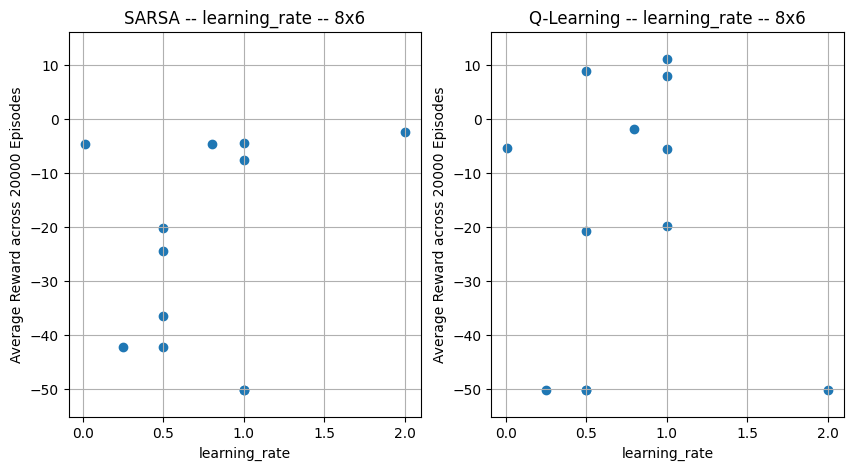

In [ ]:
plot_hyperparameter_performance('learning_rate', TRIALS_1, map_name=MAP_1_ENV.map_name)

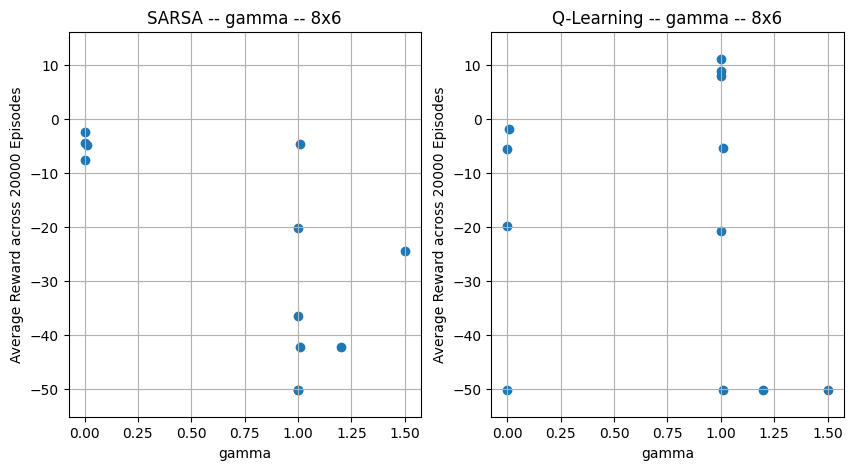

In [ ]:
plot_hyperparameter_performance('gamma', TRIALS_1, map_name=MAP_1_ENV.map_name)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


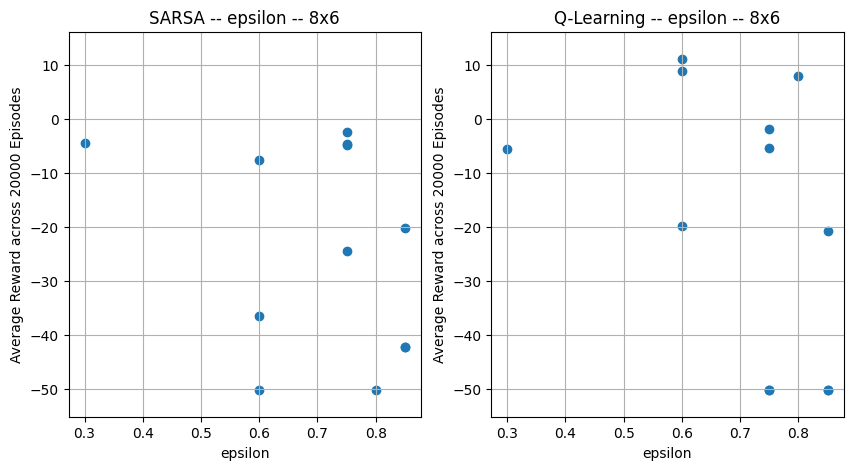

In [ ]:
plot_hyperparameter_performance('epsilon', TRIALS_1, map_name=MAP_1_ENV.map_name)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


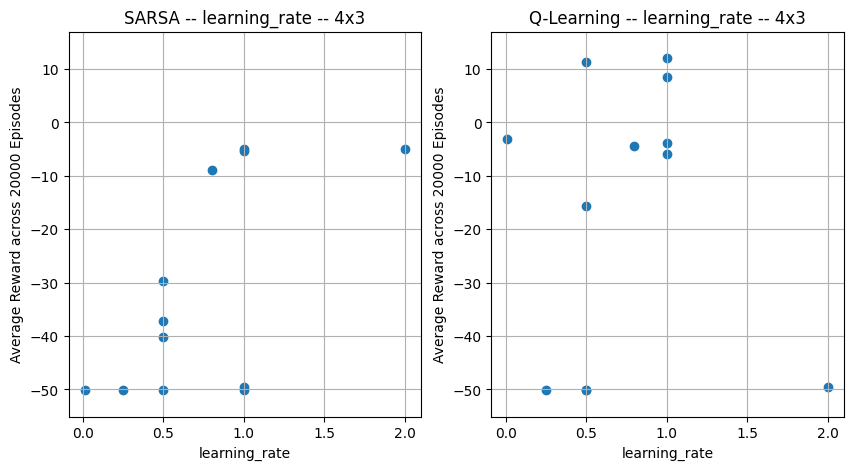

In [ ]:
plot_hyperparameter_performance('learning_rate', TRIALS_2, map_name=MAP_2_ENV.map_name)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


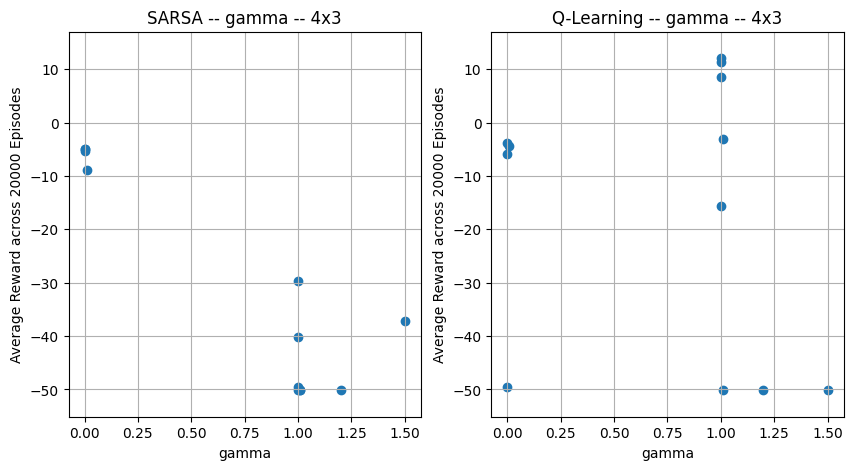

In [ ]:
plot_hyperparameter_performance('gamma', TRIALS_2, map_name=MAP_2_ENV.map_name)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


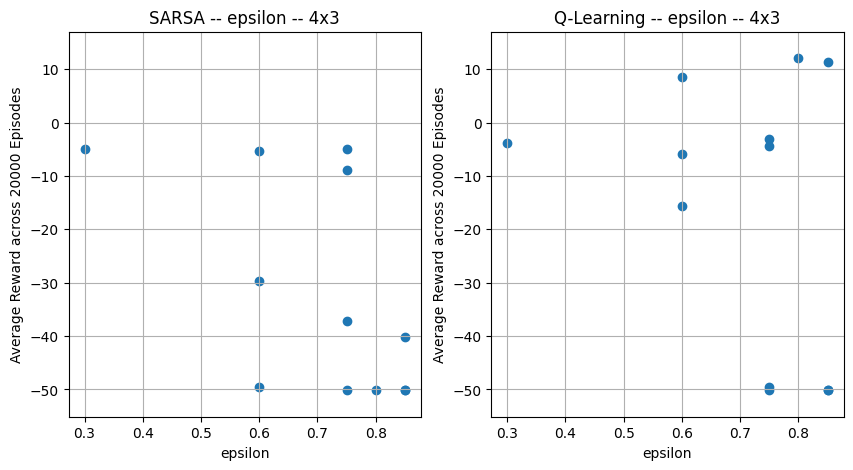

In [ ]:
plot_hyperparameter_performance('epsilon', TRIALS_2, map_name=MAP_2_ENV.map_name)

/usr/local/lib/python3.9/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
